In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode, tools_condition
import gradio as gr
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
import random

s:\Workspace\langgraph\agentic-voyage-langgraph\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import requests
import os
from langchain.agents import Tool

load_dotenv(override=True)
def telegram_push(text: str):
    """Send push notification via Telegram"""
    telegram_token = os.getenv("TELEGRAM_TOKEN")
    chat_id = os.getenv("TELEGRAM_CHAT_ID")
    
    url = f"https://api.telegram.org/bot{telegram_token}/sendMessage"
    response=requests.post(url, data={
        "chat_id": chat_id,
        "text": text
    })
    # Check response
    if response.status_code == 200:
        print("✅ Message sent successfully!")
    else:
        print(f"❌ Failed: {response.status_code}")
        print(response.text)
    
    return response

telegram_tool = Tool(
    name="telegram_push",
    func=telegram_push,
    description="Send a message to a Telegram chat"
)

telegram_tool.invoke("Hello from my script! 🚀")


✅ Message sent successfully!


<Response [200]>

In [3]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper= GoogleSerperAPIWrapper()
search_tool= Tool(
    name="search",
    func=serper.run,
    description="Search the web for information"
)




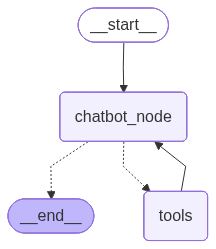

In [4]:
from typing import TypedDict

from langgraph import graph


tools=[telegram_tool, search_tool]

# Give context of the tools to the LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools)

# 1. create a state
class State(TypedDict):
    messages: Annotated[list, add_messages]
graph_builder = StateGraph(State)

# 2. create a chat node
def chatbot_node(old_state: State) -> State:
    return {"messages": [llm_with_tools.invoke(old_state["messages"])]}

# 3. create nodes
graph_builder.add_node("chatbot_node", chatbot_node)
graph_builder.add_node("tools", ToolNode(tools=tools))


# 4. create conditional edges
graph_builder.add_conditional_edges(
    "chatbot_node",
    tools_condition,
    "tools"
)

# 5. connect the nodes and edges
graph_builder.add_edge(START, "chatbot_node")
graph_builder.add_edge("tools", "chatbot_node")
graph_builder.add_edge("chatbot_node", END)


# 6. compile the graph
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [5]:
def chat(message, history):
    initial_state = State(messages=[{"role": "user", "content": message}])
    result=graph.invoke(initial_state)
    return result["messages"][-1].content

demo = gr.ChatInterface(chat,type="messages")

demo.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


✅ Message sent successfully!


In [ ]:
demo.close()

Closing server running on port: 7860


: 